<a href="https://colab.research.google.com/github/arturogaama/Deteccion-de-la-linea-de-Horizonte-utilizando-RANSAC/blob/main/Deteccion_del_horizonte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **El horizonte es la linea que aparentemente separa el cielo y la tierra.**

A continuación vamos a obtener la linea de horizonte, a partir de una imagen descargada de internet, via URL.

Detectar la linea de horizonte puede ser importante para alinear una fotografía, en topografía funciona como referencia o incluso en navegación aerea es necesaria para mantener la 'attitude' correcta.

Las librerias que vamos a utiliza son las siguientes:


**opencv:** detección de los bordes de la fotografía


**urlib:** Importar y descargar los links


**matplotlib:** Graficar en google colab


**PIL:** manipulacion de la imagen

**sklearn:** obtener la ecuación de la recta con mayor concenso mediante el algoritmo RANSAC






In [2]:
import cv2
import numpy as np
import urllib.request as urllib2
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.linear_model import RANSACRegressor

Importaremos una imagen desde una URL y la descargamos en la carpeta del proyecto bajo el nombre de 'sample.png'

In [9]:
url = 'https://elviajerofeliz.com/wp-content/uploads/2020/11/mejores-playas-del-mundo-10.jpg'
urllib2.urlretrieve(url, 'sample.png')

('sample.png', <http.client.HTTPMessage at 0x7f45a36395d0>)

Per se, no sabemos las dimensiones de la imagen descargada, así que la vamos a redimencionar a 600x400pp

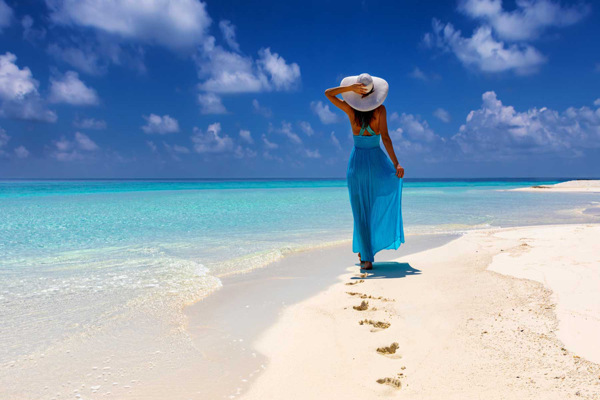

In [10]:
img = Image.open("sample.png")
img = img.resize((600,400))
img.save('sample_RS', 'png')
img

# Modificaremos la imagen para detectar los bordes

primero la transformamos a escala de grises, después, la filtramos con un 'blur' y finalmente aplicamos 'cv2.Canny' que es el filtro que obtiene los bordes. 

Despues, obtendrémos una matriz con '1' en los pixeles en donde se encuentra un borde y '0' donde no.

In [11]:
image_src = cv2.imread("sample_RS")
gray = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
mid = cv2.Canny(blurred, 30, 150)

th, binario = cv2.threshold(src=mid, thresh=127, maxval=255, type=cv2.THRESH_BINARY)
binario.shape

(400, 600)

Ya que tenemos una matriz con ceros y unos, debemos identificar las coordenadas de todos pixeles, enlistados de la sigtuiente forma:

 *{[x1, y1], [x2, y2], [x3, y3]..... [xn, yn]}, donde, n = 300*

 El valor de 'n' es  arbitrario ya que la imagen original, puede tener miles de 'puntos-borde', así que elegimos 300 aleatoriamente. Sin embargo, podemos modificar el valor de 'n'. 

In [59]:
n = 300
index = np.nonzero(binario)
sizex, sizey = binario.shape
points = np.empty(shape=[0, 2])
for y, x in zip(index[0], index[1]): points = np.append(points, [[x/sizex-1, (-y/sizey)+0.5]], axis=0)
rng = np.random.default_rng()
pointlist = rng.choice(points,n)

pointlist.shape

(300, 2)

# ¿Cómo se ven estos puntos, superpuestos sobre la imagen?

(esta superposición de puntos sobre la imagen original se puede generar directamente en opencv, sin embargo google-colab no permite desplegar nuevas ventanas, así que en este caso utilizaremos matplotlib)

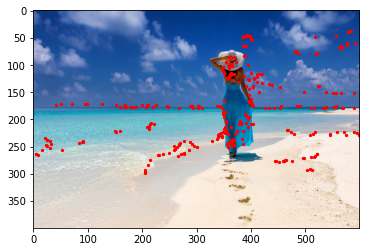

In [60]:
im = plt.imread('sample_RS')
implot = plt.imshow(im)
pointlista = pointlist*(400, 400)+(400, 100)
x, y = pointlista.T

plt.scatter(x, y, c='r', s=5)
plt.show()

Con SKLEARN y su algoritmo RANSAC obtendremos la ecuación de la recta congruente con la linea de horizonte. 

In [104]:
# El algoritmo RANSAC necesita los siguientes parámetros:

th = 3.5              # Humbral de tolerancia de la linea recta (es el grosor de la linea recta).
nstop = int(n//4)     # Condición de paro: si al menos se encuentra que el 25% de los puntos están dentro de la linea recta, RANSAC se detiene.
rstate = 11           # Ya que RANSAC es un algortimo aleatorizado, esta variable fija una semilla en la función aleatoria; con el fin de hacer reproducibles los resultados.

ransac = RANSACRegressor( residual_threshold=th, stop_n_inliers=nstop, random_state=rstate)

# Ajuste del modelo; utilizando RANSAC

In [105]:
# 1.- Redimancionamos la lista de puntos x, y de (n,) --> (n, 1)
xr_ = x.reshape(n, 1)
yr_ = y.reshape(n, 1)

# 2.- Ajustamos la mejor linea recta, acorde a los datos de entrada.
ransac.fit(xr_, yr_)

# 3.- Obtenemos los puntos que resultaron dentro y fuera del modelo en listas separadas 
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# 4.- Generamos una linea racta que pase a traves de nuestros puntos 'inliers' (es decir, los que se encuntran dentro del modelo obtenido con RANSAC)
line_x = np.arange(xr_.min(), xr_.max())[:, np.newaxis]
line_y_ransac = ransac.predict(line_x)

# IMPRESIÓN de los puntos obtenidos

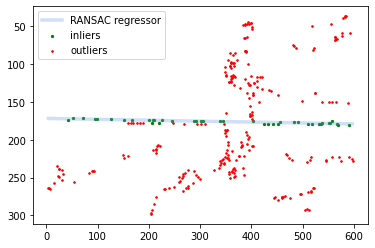

In [106]:
#impresión de todos los puntos que caen dentro de la recta: 'inliers'
plt.scatter(xr_[inlier_mask], yr_[inlier_mask], color="green", marker="." , label='inliers', s= 20)

#impresión de todos los puntos que quedan fuera de la recta: 'outliers'
plt.scatter(xr_[outlier_mask], yr_[outlier_mask], color="red", marker=".", label='outliers', s= 10 )

#impresión de la linea reta calculada
plt.plot( line_x, line_y_ransac, color="cornflowerblue", linewidth=th, label="RANSAC regressor", alpha=0.3)

#letreros
plt.gca().invert_yaxis()
plt.legend(loc="upper left")
plt.show()